# Pipeline

In [1]:
# Imports

import torch

import networkx as nx

import numpy as np
import pandas as pd
import scipy.io
 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import pickle

from tensorly.decomposition import tucker, constrained_parafac

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

from scipy.sparse import csr_matrix, issparse

from SSLH_inference import *
from SSLH_utils import *

### Load Network & Ego Nets

In [2]:
def load_network(path):
    
    try:
        data = scipy.io.loadmat(path)
    except:
        print('Invalid data path')

    G = nx.from_scipy_sparse_array(data["Network"])
    # nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
    print(str(G))

    # convert list of lists to list
    labels = [j for i in data["Label"] for j in i]

    # Add labels to each node
    for i in range(len(G.nodes)):
        G.nodes[i]['Anomaly'] = labels[i]

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    if len(labels) != G.number_of_nodes():
        labels = list(nx.get_node_attributes(G, 'Anomaly').values())

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
        # else:
        #     # label is out of consideration
        #     print("yes")
        #     del labels[i]

    return G, ego_gs, roots, labels

In [3]:
G, ego_gs, roots, labels = load_network(input('Enter dataset path: '))

roots = [int(r) for r in roots]

Graph with 7575 nodes and 241482 edges


  0%|          | 0/7575 [00:00<?, ?it/s]

In [4]:
print(f'Using {len(ego_gs)} egonets')

Using 7575 egonets


### Separate Anomalies

In [24]:
# 1: anomalous egonet ==> anomalous root
# 2: anomalous egonet ==> any anomalous node

print('1: anomalous egonet ==> anomalous root')
print('2: anomalous egonet ==> any anomalous node')

anom_def = int(input('Anomalous definition: '))

1: anomalous egonet ==> anomalous root
2: anomalous egonet ==> any anomalous node


In [25]:
# get anomalous egonets for definition 2
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [26]:
anom_gs, clean_gs = [], []
if anom_def == 1:
    for idx, root_attr in enumerate(tqdm(roots)):
        if root_attr == 1:
            anom_gs.append(ego_gs[idx])
        else:
            clean_gs.append(ego_gs[idx])
elif anom_def == 2:
    for idx, g in enumerate(tqdm(ego_gs)):
        # check if root is anomolous first
        if is_anomolous(g):
            anom_gs.append(g)
        else:
            clean_gs.append(g)
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/16445 [00:00<?, ?it/s]

# of anomalous graphs: 4633/16445
# of clean graphs: 11812/16445


### Build Tensor

In [5]:
slice_size = int(input("Input a slice size for tensor: "))

In [6]:
cube = torch.empty((1, slice_size, slice_size, slice_size))

for i in tqdm(range(len(ego_gs[:slice_size]))):
    slice_gs = nx.to_numpy_array(ego_gs[i])[:slice_size, :slice_size]
    result = np.zeros((slice_size, slice_size))
    result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
    ten = torch.as_tensor(result)
    dim = ten.shape[0]
    cube[0, :dim, :dim, i] = ten

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
# padding adjacency matrices

# padded_anom = []
# for gs in tqdm(anom_gs):
#     g = nx.to_numpy_array(gs)
#     padded = np.zeros((slice_size, slice_size))
#     if len(padded) >= len(g):
#         padded[:g.shape[0], :g.shape[1]] = g
#     else:
#         padded = g[:slice_size, :slice_size]
#     padded_anom.append(padded)
    
# padded_clean = []
# for gs in tqdm(clean_gs):
#     g = nx.to_numpy_array(gs)
#     padded = np.zeros((slice_size, slice_size))
#     if len(padded) >= len(g):
#         padded[:g.shape[0], :g.shape[1]] = g
#     else:
#         padded = g[:slice_size, :slice_size]
#     padded_clean.append(padded)

padded_gs = []
for gs in tqdm(ego_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_gs.append(padded)

  0%|          | 0/7575 [00:00<?, ?it/s]

In [10]:
# anom_y = np.zeros(len(anom_gs))
# clean_y = np.zeros(len(clean_gs))

### Tensor Decomposition + Reconstruction Error

In [8]:
ranks = [int(r) for r in input('Enter ranks, space separated: ').split()]

  0%|          | 0/7575 [00:00<?, ?it/s]

(7575, 1) (7575, 1) (7575, 1)
0.5850910065083442


<Figure size 640x480 with 0 Axes>

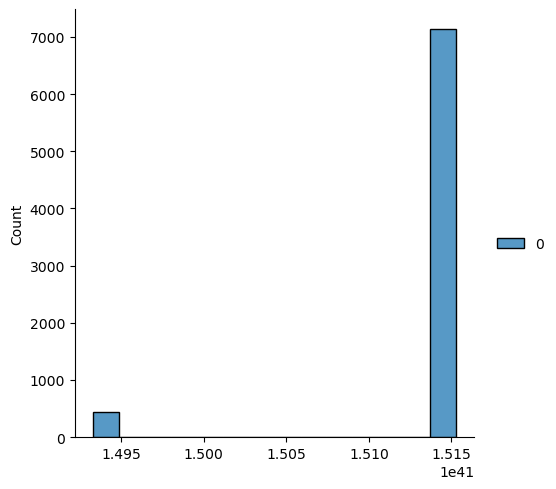

<Figure size 640x480 with 0 Axes>

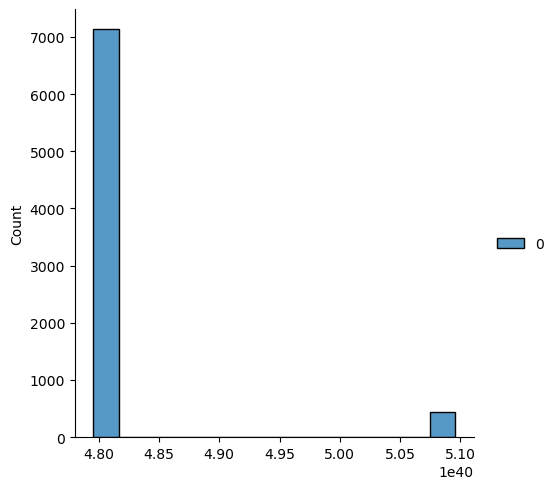

In [9]:
for rank in ranks:
    load = input('Load previous decomposition? (y/n): ')
    if load.lower()[0] == 'n':
        print(f'USING RANK {rank}\n')
        path = input('Enter file name to save as: ') + '.sav'
        decomp = input('Select Tucker (1) or CP (2) decomposition: ')
        if decomp == '1':
            core, factors = tucker(cube[0].numpy(), rank=rank)
        elif decomp == '2':
            weights, factors = constrained_parafac(cube[0].numpy(), rank=rank)
        saved_model = open(path, 'wb')
        pickle.dump(factors, saved_model)
        saved_model.close()
    else:
        with open(input('Enter file path: '), 'rb') as f:
            factors = pickle.load(f)
            f.close()
    
    A, B, C = factors
    A, B, C, = np.array(A), np.array(B), np.array(C)
    
#     results_anom = []
#     for gs in tqdm(padded_anom):
#         gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
#         d = np.linalg.norm(gs - gs_p)
#         results_anom.append(d)
        
#     results_clean = []
#     for gs in tqdm(padded_clean):
#         gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
#         d = np.linalg.norm(gs - gs_p)
#         results_clean.append(d)


    errors = []
    for gs in tqdm(padded_gs):
        gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
        d = np.linalg.norm(gs - gs_p)
        errors.append(d)


    ## BELIEF PROPOGATION

    errors = np.array(errors).reshape(-1, 1)
    
    # adjusted for homophily
    H = np.flip(create_parameterized_H(1, 8, symmetric=True), axis=1)
    W = csr_matrix(np.ones((len(errors), len(errors))))
    X = errors
    
    out = linBP_symmetric(X, W, H)
    
    scale = MinMaxScaler()
    embeddings = scale.fit_transform(np.array(out))

    print(embeddings.shape, out.shape, X.shape)
    
    print(roc_auc_score(labels, embeddings))
    
    plt.figure()
    sns.displot(out[labels])
    
    plt.figure()
    sns.displot(out[~np.array(labels)])
    
    ## CLUSTERING
    
#     clus_method = input('Enter clustering method (1) Isolation Forest or (2) K-Means: ')
        
#     ## PLOTS
    
#     plt.figure(figsize=(15,5))
#     plt.title('Reconstruction Error')
#     if len(anom_y) > len(clean_y):
#         sns.scatterplot(x=results_anom, y=anom_y, marker='x')
#         sns.scatterplot(x=results_clean, y=clean_y, marker='o')
#         plt.scatter([np.median(results_anom)], 0, c='red')
#         plt.scatter([np.median(results_clean)], 0, c='blue')
#     else:
#         sns.scatterplot(x=results_clean, y=clean_y, marker='o')  
#         sns.scatterplot(x=results_anom, y=anom_y, marker='x')
#         plt.scatter([np.median(results_anom)], 0, c='red')
#         plt.scatter([np.median(results_clean)], 0, c='blue')

#     plt.legend(['Anom', 'Clean'])
    
#     plt.figure()
#     sns.scatterplot(x=results_anom, y=[0] * len(anom_y), marker='x')
#     sns.scatterplot(x=results_clean, y=[1] * len(clean_y), marker='o')
#     plt.scatter([np.median(results_anom)], 0, c='red')
#     plt.scatter([np.median(results_clean)], 1, c='blue')
    
#     plt.figure(figsize=(15,5))
#     plt.title('Reconstruction Error')
#     sns.histplot(results_anom)
#     sns.histplot(results_clean, ax=plt.gca())
    
#     plt.figure(figsize=(15,5))
#     plt.title('Reconstruction Error')
#     comb = [results_clean, results_anom]
#     plt.boxplot(comb)
    
    
#     ## KMEANS - 2 clusters
    
#     results, true_labels = [], []
#     results.extend(results_clean); results.extend(results_anom)
#     true_labels.extend([0] * len(results_clean)); true_labels.extend([1] * len(results_anom))
    
#     results = np.array(results).reshape(-1, 1)
        
#     if clus_method == '1':
#         ifor = IsolationForest()
#         pred = ifor.fit_predict(results)
#         labels = [1 if p == -1 else 0 for p in pred]
#         plt.title('IF Clustering')
#         sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
#         plt.scatter([np.median(results_anom)], 0, c='red')
#         plt.scatter([np.median(results_clean)], 0, c='blue')
#     elif clus_method == '2':
#         plt.figure(figsize=(15,5))
#         plt.title('K-Means')
#         kmeans = KMeans(n_clusters=2, random_state=1).fit(results)
#         sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)
#         plt.scatter([np.median(results_anom)], 0, c='red')
#         plt.scatter([np.median(results_clean)], 0, c='blue')
#         labels = kmeans.labels_
    
#     print(np.unique(true_labels, return_counts=True))
#     print(np.unique(labels, return_counts=True))

#     print(classification_report(true_labels, labels))